# Skipgram Model using MXNet/Gluon

## Introduction

This tutorials aims to teach how to implement word2vec skipgram model(negative sampling) with gluon interface.  
However note that python is not suitable for training word2vec model, data iterator in mxnet is limited to be single threaded and   additional trick is required for asynchronous SGD. This tutorial is for demonstration purpose only.  

## Other resources

For high performance library refer to  

 - cython version [Genism](https://radimrehurek.com/gensim/models/word2vec.html), 
 - or Original C version [Google](https://code.google.com/archive/p/word2vec/)

## CBOW version

Peopel who are interested in cbow model of word2vec(nce loss), refer to  
[CBOW](https://github.com/apache/incubator-mxnet/blob/master/example/nce-loss/wordvec.py)



## You will acquire the following:

- explain what skipgram model is
- implement custom blocks with Gluon Inteface, 
- extract, save and load parameters

## Prerequisites

To complete this tutorial, you need:

- [MXNet/Gluon](http://mxnet.io/get_started/setup.html#overview)
- [Language](https://www.python.org/)
- [Embedding Benchmark](https://github.com/kudkudak/word-embeddings-benchmarks)
- Familiarity with linear algebra, simple multi layer perceptron

In [2]:
import time
import numpy as np
import logging
import sys, random, time, math
import mxnet as mx
from mxnet import nd
from mxnet import gluon
from mxnet.gluon import Block, nn
from mxnet import autograd
import _pickle as cPickle
import collections
import math
import os
import random
from tempfile import gettempdir
import zipfile
from six.moves import urllib
from six.moves import xrange  # pylint:

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/urllib3/contrib/pyopenssl.py:46: DeprecationWarning: OpenSSL.rand is deprecated - you should use os.urandom instead
  import OpenSSL.SSL


## The Data

[text8](http://mattmahoney.net/dc/textdata.html) **wikipedia dump**

In [3]:
url = 'http://mattmahoney.net/dc/'
def maybe_download(filename, expected_bytes):
  """Download a file if not present, and make sure it's the right size."""
  local_filename = os.path.join(gettempdir(), filename)
  if not os.path.exists(local_filename):
    local_filename, _ = urllib.request.urlretrieve(url + filename,
                                                   local_filename)
  statinfo = os.stat(local_filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', filename)
  else:
    print(statinfo.st_size)
    raise Exception('Failed to verify ' + local_filename +
                    '. Can you get to it with a browser?')
  return local_filename

filename = maybe_download('text8.zip', 31344016)

Found and verified text8.zip


split into list of words

In [4]:
def read_data(filename):
  """Extract the first file enclosed in a zip file as a list of words."""
  with zipfile.ZipFile(filename) as f:
    data = str(f.read(f.namelist()[0]))
  return data
buf = read_data(filename)
vocabulary = buf.split()

## Prepare the Data

In [7]:
def build_dataset(words, n_words):
    dictionary = {}
    reverse_dictionary = ["NA"]
    count = [0] 
    data = [] 
    for word in vocabulary:
        if len(word) == 0:
            continue
        if word not in dictionary:
            dictionary[word] = len(dictionary) + 1
            count.append(0)
            reverse_dictionary.append(word)
        wid = dictionary[word]
        data.append(wid)
        count[wid] += 1
    negative = [] 
    for i, v in enumerate(count):
        if i == 0 or v < 5:
            continue
        v = int(math.pow(v * 1.0, 0.75))
        negative += [i for _ in range(v)]
    return data, count, dictionary, reverse_dictionary, negative
vocabulary_size = 50000
data, count, dictionary, reverse_dictionary, negative = build_dataset(vocabulary, vocabulary_size)

### From the raw text, we will build the followings

#### Dictionary
dictionary['apple'] returns integer index
#### Reverse dictionary 
reverse_dictionary['21'] returns corresponding word
#### Count
count['apple'] returns the occurences of apple in the corpus
#### Negative
this table will be used for sampling words in the training phase
#### Data
sequence of word is converted to sequence of indices, using dictionary

### Build Data Iterator

In [8]:
class DataBatch(object):
    def __init__(self, data, label):
        self.data = data
        self.label = label

class Word2VecDataIterator(mx.io.DataIter):
    def __init__(self, batch_size=512, num_neg_samples=5, window=5):
        super(Word2VecDataIterator, self).__init__()
        self.batch_size = batch_size
        self.negative_samples = num_neg_samples
        self.window = window
        self.data, self.negative, self.dictionary, self.freq = (data, negative, dictionary, count)

    @property
    def provide_data(self):
        return [('contexts', (self.batch_size, 1))]

    @property
    def provide_label(self):
        return [('targets', (self.batch_size, self.negative + 1))]

    def sample_ne(self):
        return self.negative[random.randint(0, len(self.negative) - 1)]

    def __iter__(self):
        input_data = []
        update_targets = []
        for pos, word in enumerate(self.data):
            for index in range(-self.window, self.window + 1, 2):
                if (index != 0 and pos + index >= 0 and pos + index < len(self.data)):
                    if self.freq[word] < 5:
                        continue
                    context = self.data[pos + index]
                    if word != context:
                        input_data.append([word])
                        targets = []
                        targets.append(context) # positive sample
                        while len(targets) < self.negative_samples + 1: # negative sample
                            w = self.sample_ne()
                            if w != word:
                                targets.append(w)
                        update_targets.append(targets)

            # Check if batch size is full
            if len(input_data) > self.batch_size:
                batch_inputs = [mx.nd.array(input_data[:self.batch_size])]
                batch_update_targets = [mx.nd.array(update_targets[:self.batch_size])]
                yield DataBatch(batch_inputs, batch_update_targets)
                input_data = input_data[self.batch_size:]
                update_targets = update_targets[self.batch_size:]


![training-data](http://mccormickml.com/assets/word2vec/training_data.png)
## For example
if the size of the vocabulary is 10,  
then the size of the input and output layer is 10.  
(size, meaning number of unit in a layer)  
output will be something like this (0, 0.1, 0.7, 0.1, 0.1, 0, 0, 0, 0, 0)  

### Why 1 Hot Encoding?
1 hot encoded input will select only the corresponding row from the input weight matrix.  
**note** input weight matrix connects input and the hidden layer, this matrix is the vector we are trying to learn. (= word vectors)   

### Why Negative Sampling? 
At each training phase, we will not be calculating softmax loss over entire vocabulary.  
we will designate specific units to perform update on.  
thus a training sample will consists of context word that actually appears and five others that doesn't.   
negative samples are selected from the negative table we have built previously.  

e.g.)
"the quick"  
  
center : quick  
context : the  
  
postive sample (quick,the)  
negative sample (quick, fox)  
negative sample (quick, jump)  
negative sample (quick, cat)  
negative sample (quick, runs)  
negative sample (quick, of)  

In [9]:
dictionary_size = len(reverse_dictionary)
batch_size = 512
num_hiddens = 100
num_negative_samples = 5

ctx = mx.gpu()
data_iterator = Word2VecDataIterator(batch_size=batch_size,
                                     num_neg_samples=num_negative_samples,
                                     window=5)
batches = []
counting = 0


In [10]:
for batch in data_iterator:
    batches.append(batch)
    if (counting % 500 == 0):
        print(counting)
    #if (counting > 100000) : break
    counting = counting + 1
    
cPickle.dump(batches, open('batches.p', 'wb'))

0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
10000
10500
11000
11500
12000
12500
13000
13500
14000
14500
15000
15500
16000
16500
17000
17500
18000
18500
19000
19500
20000
20500
21000
21500
22000
22500
23000
23500
24000
24500
25000
25500
26000
26500
27000
27500
28000
28500
29000
29500
30000
30500
31000
31500
32000
32500
33000
33500
34000
34500
35000
35500
36000
36500
37000
37500
38000
38500
39000
39500
40000
40500
41000
41500
42000
42500
43000
43500
44000
44500
45000
45500
46000
46500
47000
47500
48000
48500
49000
49500
50000
50500
51000
51500
52000
52500
53000
53500
54000
54500
55000
55500
56000
56500
57000
57500
58000
58500
59000
59500
60000
60500
61000
61500
62000
62500
63000
63500
64000
64500
65000
65500
66000
66500
67000
67500
68000
68500
69000
69500
70000
70500
71000
71500
72000
72500
73000
73500
74000
74500
75000
75500
76000
76500
77000
77500
78000
78500
79000
79500
80000
80500
81000
81500
82000
82500
83000
83500
84000
84500
8500

In [11]:
# batches = cPickle.load(open('batches.p', 'rb'))

## Create the Model

In [12]:
class Model(gluon.HybridBlock):
    def __init__(self, **kwargs):
        super(Model, self).__init__(**kwargs)
        with self.name_scope():
            self.center = nn.Embedding(input_dim=dictionary_size,
                                       output_dim=num_hiddens,
                                       weight_initializer=mx.initializer.Uniform(1.0 / num_hiddens))

            self.target = nn.Embedding(input_dim=dictionary_size,
                                       output_dim=num_hiddens,
                                       weight_initializer=mx.initializer.Zero())

    def hybrid_forward(self, F, center, targets, labels):
        input_vectors = self.center(center)
        update_targets = self.target(targets)
        predictions = F.broadcast_mul(input_vectors, update_targets)
        predictions = F.sum(data=predictions, axis=2)
        sigmoid = F.sigmoid(predictions)
        loss = F.sum(labels * F.log(sigmoid) + (1 - labels) * F.log(1 - sigmoid), axis=1)
        loss = loss * -1.0 / batch_size
        loss_layer = F.MakeLoss(loss)
        return loss_layer
model = Model()
model.initialize(ctx=ctx)
model.hybridize()

![skipgram-architecture](http://mccormickml.com/assets/word2vec/skip_gram_net_arch.png)
## Architecture
given a word, cbow and skipgram model both tries to predict a word.  
for skipgram the input is the **center** word, and output is the probability of a **context** word.  
input layer takes a single word(1 hot encoded) and output layer outputs probability of every word appearing in the context. 

### Center embedding
from the 1hot encoded input, we will be selecting word vectors from the weight matrix
only a single row will be selected
  
### Target embedding
from the target (postive sample, negative sample1,  negative sample2,  negative sample3,  negative sample4,  negative sample5)
only the 6 row will be selected
  
### Calculation

The skipgram architecture tries to predict the context given a word. The problem of predicting context words is framed as a set of independent binary classification tasks. Then the goal is to independently predict the presence (or absence) of context words. For the word at position $t$ we consider all context words as positive examples and sample negatives at random from the dictionary. For a chosen context position $c$, using the binary logistic loss, we obtain the following negative log-likelihood:

$$ \log (1 + e^{-s(w_t, w_c)}) +  \sum_{n \in \mathcal{N}_{t,c}}^{}{\log (1 + e^{s(w_t, n)})}$$

where $w_t$ is a center word, $w_c$ is a context word, $\mathcal{N}_{t,c}$ is a set of negative examples sampled from the vocabulary. By denoting the logistic loss function $l : x \mapsto \log(1 + e^{-x})$, we can re-write the objective as:

$$ \sum_{t=1}^{T}{ \sum_{c \in C_t}^{}{ \big[ l(s(w_t, w_c))} + \sum_{n \in \mathcal{N}_{t,c}}^{}{l(-s(w_t, n))}   \big]} $$

where $s(w_t, w_c) = u_{w_t}^T v_{w_c}$


## Fit the Model

In [15]:
trainer = gluon.Trainer(model.collect_params(), 'sgd', {'learning_rate': 4, 'clip_gradient': 5})

labels = nd.zeros((batch_size, num_negative_samples + 1), ctx=ctx)
labels[:, 0] = 1 # [1 0 0 0 0 0]
start_time = time.time()
num_epochs = 1


def get_loss(epoch_n, batch_n, moving_loss, loss):
    if(batch_n==0 and epoch_n==0):
        return (loss.asnumpy().sum())
    else:
        return (.99 * moving_loss + .01 * loss.asnumpy().sum())
    return loss

for e in range(num_epochs):
    moving_loss = 0.
    for i, batch in enumerate(batches):
        center_words = batch.data[0].as_in_context(ctx)
        target_words = batch.label[0].as_in_context(ctx)
        with autograd.record():
            loss = model(center_words, target_words, labels)
        loss.backward()
        # ignore_stale_grad ; only update calculated target weights
        trainer.step(1, ignore_stale_grad=True)
        #  Keep a moving average of the losses
        moving_loss = get_loss(e, i , moving_loss, loss)
        if (i + 1) % 1000 == 0:
            print("%sth epoch , %sth batch. moving loss: %s" % (e, i, moving_loss))
    print("1 epoch took %s seconds" % (time.time() - start_time))

0th epoch , 999th batch. moving loss: 2.95111595521
0th epoch , 1999th batch. moving loss: 2.85901880619
0th epoch , 2999th batch. moving loss: 2.83284521181
0th epoch , 3999th batch. moving loss: 2.84230094075
0th epoch , 4999th batch. moving loss: 2.73847775527
0th epoch , 5999th batch. moving loss: 2.71560624747
0th epoch , 6999th batch. moving loss: 2.60565524943
0th epoch , 7999th batch. moving loss: 2.62472409271
0th epoch , 8999th batch. moving loss: 2.57682812064
0th epoch , 9999th batch. moving loss: 2.57023631357
0th epoch , 10999th batch. moving loss: 2.51439515383
0th epoch , 11999th batch. moving loss: 2.49447523281
0th epoch , 12999th batch. moving loss: 2.46921071119
0th epoch , 13999th batch. moving loss: 2.60498841949
0th epoch , 14999th batch. moving loss: 2.46585849155
0th epoch , 15999th batch. moving loss: 2.49867734292
0th epoch , 16999th batch. moving loss: 2.49029687324
0th epoch , 17999th batch. moving loss: 2.4175361302
0th epoch , 18999th batch. moving loss: 

0th epoch , 152999th batch. moving loss: 2.21150962469
0th epoch , 153999th batch. moving loss: 2.13815389997
0th epoch , 154999th batch. moving loss: 2.21854544929
0th epoch , 155999th batch. moving loss: 2.25393886712
0th epoch , 156999th batch. moving loss: 2.2479741655
0th epoch , 157999th batch. moving loss: 2.26863425718
0th epoch , 158999th batch. moving loss: 2.234350637
0th epoch , 159999th batch. moving loss: 2.27398211595
0th epoch , 160999th batch. moving loss: 2.24678013919
0th epoch , 161999th batch. moving loss: 2.20073204366
0th epoch , 162999th batch. moving loss: 1.99518301752
0th epoch , 163999th batch. moving loss: 2.24013614045
0th epoch , 164999th batch. moving loss: 2.25242615966
0th epoch , 165999th batch. moving loss: 2.18106116184
0th epoch , 166999th batch. moving loss: 2.18714659016
0th epoch , 167999th batch. moving loss: 2.25232721178
0th epoch , 168999th batch. moving loss: 2.12338396052
0th epoch , 169999th batch. moving loss: 2.31114832921
0th epoch , 1

We will use large batch size 512, update weights by sgd.  
**note** original c version of w2vec uses batch size 1, asynchronous sgd.  

## Save Word Vectors

In [16]:
# format index : vector
key = list(model.collect_params().keys())
all_vecs = model.collect_params()[key[0]].data().asnumpy()
cPickle.dump(all_vecs, open('all_vecs.p', 'wb'))

#  foramt word : vector
w2vec_dict = dictionary.copy()
for word in dictionary:
    idx = dictionary[word]
    vector = all_vecs[idx]
    w2vec_dict[word] = vector

cPickle.dump(w2vec_dict, open('w2vec_dict.p', 'wb'))

## Evaluation

### T-SNE Visualization

In [17]:
top_50k = (-np.array(count)).argsort()[0:50000]
word_to_index = {}
index_to_word = []
for newid, word_id in enumerate(top_50k):
    index_to_word.append(reverse_dictionary[word_id])
    word_to_index[reverse_dictionary[word_id]] = newid

In [18]:
from sklearn.manifold import TSNE

num_points = 450

tsne = TSNE(perplexity=50, n_components=2, init='pca', n_iter=10000)
two_d_embeddings = tsne.fit_transform(all_vecs[:num_points])
labels = index_to_word[:num_points]

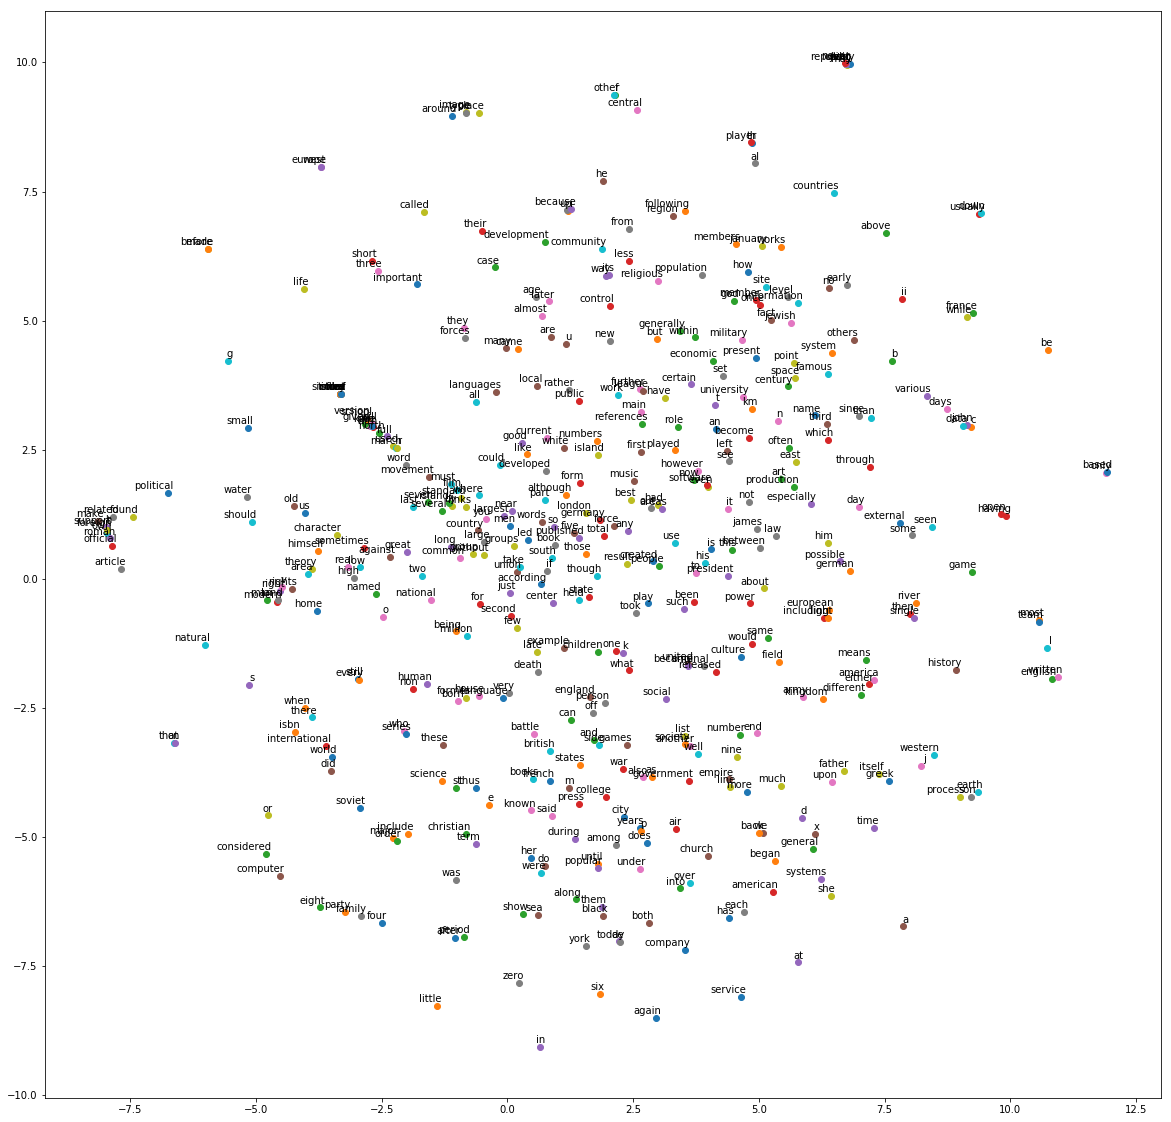

In [19]:
from matplotlib import pylab

%matplotlib inline

def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(20,20))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
  pylab.show()

plot(two_d_embeddings, labels)

### Word Embedding
(optional) word embediing bench mark  
[Embedding Benchmark](https://github.com/kudkudak/word-embeddings-benchmarks)

In [20]:
import logging
from web.datasets.analogy import fetch_google_analogy
from web.embeddings import fetch_SG_GoogleNews
import numpy as np
import _pickle as pickle
from web.embeddings import load_embedding

In [21]:
w = load_embedding("w2vec_dict.p", format="dict")
data = fetch_google_analogy()

### analogy question

In [41]:
# demo task1
subset = [13500, 13700, 13800, 12000, 12005]
for id in subset:
    w1, w2, w3 = data.X[id][0], data.X[id][1], data.X[id][2]
    print("Question: {} is to {} as {} is to ?".format(w1, w2, w3))
    print("Answer: " + data.y[id])
    print("Predicted: " + " ".join(w.nearest_neighbors(w[w2] - w[w1] + w[w3], exclude=[w1, w2, w3])))

Question: increase is to increasing as code is to ?
Answer: coding
Predicted: kernel
Question: play is to playing as listen is to ?
Answer: listening
Predicted: listening
Question: say is to saying as see is to ?
Answer: seeing
Predicted: timeline
Question: young is to younger as tight is to ?
Answer: tighter
Predicted: closing
Question: bad is to worst as big is to ?
Answer: biggest
Predicted: biggest


### 5 nearest word

In [28]:
# demo task2
targets = ["south", "usa", "eight", "earth", "god"]
print("top 5 similar words list")
for target in targets:
    print("'"+target+"': "+str(w.nearest_neighbors(w[target], k = 5,  exclude = [target])))

top 5 similar words list
'south': ['north', 'west', 'southwest', 'northwest', 'northeast']
'usa': ['honolulu', 'melbourne', 'toronto', 'florida', 'kansas']
'eight': ['seven', 'six', 'hardcover', 'five', 'feb']
'earth': ['sun', 'moon', 'planet', 'orbit', 'surface']
'god': ['spirit', 'jesus', 'allah', 'messiah', 'christ']


### cosine similarity between two words

In [29]:
# demo task3
print("cosine similarity measure")
word_pairs = [("france", "spain"),("newton", "apple"),("coke", "hamburger")]
for pair in word_pairs :
    cosine_similarity = np.dot(w[pair[0]], w[pair[1]])/(np.linalg.norm(w[pair[0]])* np.linalg.norm(w[pair[1]]))
    print("similarity score {} , {} : {} ".format(pair[0], pair[1] ,cosine_similarity))

cosine similarity measure
similarity score france , spain : 0.9003657698631287 
similarity score newton , apple : 0.5271580219268799 
similarity score coke , hamburger : 0.9221870303153992 


## evaluate on all

In [42]:
from web.evaluate import evaluate_on_all
out_fname = "results.csv"
results = evaluate_on_all(w)
print("Saving results...")
print(results)
results.to_csv(out_fname)


Dataset created in /home/ubuntu/web_data/similarity



Missing 10 words. Will replace them with mean vector
Missing 24 words. Will replace them with mean vector
Missing 16 words. Will replace them with mean vector
Missing 11 words. Will replace them with mean vector
Missing 539 words. Will replace them with mean vector
Missing 1 words. Will replace them with mean vector



Dataset created in /home/ubuntu/web_data/analogy/EN-MSR



Missing 378 words. Will replace them with mean vector
/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/web-0.0.1-py3.6.egg/web/analogy.py:98: DeprecationWarning: generator 'batched' raised StopIteration
  for id_batch, batch in enumerate(batched(range(len(X)), self.batch_size)):
Missing 738 words. Will replace them with mean vector
/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/scipy/stats/stats.py:245: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)


Saving results...
        AP  BLESS    Battig  ESSLI_1a  ESSLI_2b  ESSLI_2c       MEN     MTurk  \
0  0.30597   0.33  0.214491  0.522727      0.65  0.466667  0.252986  0.267037   

       RG65        RW  SimLex999     WS353    WS353R    WS353S    Google  \
0  0.262723  0.127091   0.199033  0.382539  0.247017  0.489005  0.059097   

       MSR  SemEval2012_2  
0  0.09075       0.102172  
